In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
print(tf.__version__)

2.7.0


In [3]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

1


In [4]:

#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
class Compression:
    def __init__(self,model):
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(0.01,0,False)
        self.acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.test_accuracy = tf.keras.metrics.Accuracy()
        self.test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.train_accuracy = tf.keras.metrics.Accuracy()
        self.model = model

    def train(self,epochs,train_ds,test_ds, alpha, n_bits,learning_rate):
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.epochs = epochs
        self.alpha = alpha
        self.n_bits = n_bits
        self.learning_rate = learning_rate

        np.set_printoptions(threshold=np.inf)
        model_sparsity = np.array([])
        model_sparsity_layers = np.array([])
        model_train_loss = np.array([])
        model_train_acc = np.array([])
        model_test_loss = np.array([])
        model_test_acc = np.array([])
        sparsity = 0

        #CONVERT BIAS OF ZEROS TO ONES
        for layer in self.model.trainable_weights:
            if 'bias' in layer.name:
                new_bias = tf.cast(tf.where(tf.abs(layer) > 0, 1,1), tf.float32)
                layer.assign(new_bias)


        for epoch in range(self.epochs):
            #print("\n---------------------Start of epoch %d------------------" % (epoch,))
            # Iterate over the batches of the dataset.
            acc_epoch_mean = np.array([])
            loss_epoch_mean = np.array([])

            acct_epoch_mean = np.array([])
            losst_epoch_mean = np.array([])
            for step, (x_batch_train, y_batch_train) in enumerate(self.train_ds):
                

                #print("Depois - depois")
                #print(self.model.trainable_weights[0][0])

                #PRUNING
                if self.alpha <= 0:
                    bk = [0]*len(self.model.trainable_weights)
                    print("menor")
                else:
                    bk,sparsity = self.pruning()

                



                '''
                if self.alpha <=0:
                    bk = [0]*len(self.model.trainable_weights)
                else:
                    bk = []
                #PRUNING
                if self.alpha > 0:
                    for layer_weights in self.model.trainable_weights:
                        # flatten weights
                        f_weights = tf.reshape(layer_weights, [-1])
                        # get standard deviation of each layer
                        lim = self.alpha * tf.math.reduce_std(f_weights)
                        bk.append(lim)
                        # create a mask
                        mask = tf.cast(tf.where(tf.abs(layer_weights) > lim, 1, 0), tf.float32)
                        # assign pruned weights to the layer
                        layer_weights.assign(tf.math.multiply(layer_weights, mask))
                        flat_array = np.array((tf.reshape(mask, [-1])))
                        n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                        size += flat_array.shape[0]
                        sparsity = n_zeros * 100 / size
                '''

                #CREATE A COPY OF THE MODEL TO P->Q
                model_copy = keras.models.clone_model(self.model)
                model_copy.set_weights(self.model.get_weights())

                #QUANTIZATION


                if self.n_bits > 0:
                    self.quantization(bk)


                '''
                if step == -500 and epoch == -100:
                    pass
                else:
                    if self.n_bits > 0:
                        for i, layer_weights in enumerate(self.model.trainable_variables):
                            qk_line = (tf.reduce_max(tf.math.abs(layer_weights))-bk[i]) / (2 ** (self.n_bits - 1) - 1)
                            ck = tf.math.round(layer_weights / qk_line) * qk_line
                            layer_weights.assign(ck)
                '''

                tape = tf.GradientTape(persistent=True)
                tape._push_tape()
                pred = self.model(x_batch_train, training=False)
                loss = self.loss_fn(y_batch_train, pred)
                tape._pop_tape()

                grads = tape.gradient(loss, self.model.trainable_weights)
                tape._tape=None

                #OPTIMIZER
                if self.n_bits > 0 and self.alpha > 0:
                    for i, (layer_weights, pruned) in enumerate(zip(self.model.trainable_weights, model_copy.trainable_weights)):
                        grads[i] = grads[i] * self.learning_rate
                        #WEIGHT UPDATE
                        layer_weights.assign(tf.math.subtract(pruned,grads[i]))
                        
                elif self.alpha <= 0:
                    for i, (layer_weights, pruned) in enumerate(zip(self.model.trainable_weights, model_copy.trainable_weights)):
                        grads[i] = grads[i] * self.learning_rate
                        #WEIGHT UPDATE
                        layer_weights.assign(tf.math.subtract(layer_weights,grads[i]))
                
                predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
                acc = self.train_accuracy(y_batch_train, predictions)

                acc_epoch_mean = np.append(acc_epoch_mean, acc)
                loss_epoch_mean = np.append(loss_epoch_mean, loss)

            #PRUNING
            if self.alpha <=0:
                bk = [0]*len(self.model.trainable_weights)
            else:
                bk,sparsity = self.pruning()
                
            #QUANTIZATION
            if self.n_bits > 0:
                self.quantization(bk)
            '''
            #PLOT WEIGHTS
            a = tf.reshape(model_cifar.trainable_weights[2],[-1])
            #print(a)
            plt.ylim(0,4000)
            plt.hist(a,100)
            plt.show()
            '''    


                #if step % 200 == 0:
                    #print("So far", step, "m_batches ->", "train loss =", float(loss), "train acc =", float(acc * 100), "sparsity =", sparsity)

            # Validation
            for step, (x_batch_test, y_batch_test) in enumerate(self.test_ds):
                test_pred = self.model(x_batch_test, training=False)
                test_loss = self.loss_fn(y_batch_test, test_pred)
                test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
                test_acc = self.test_accuracy(y_batch_test, test_prediction)

                acct_epoch_mean = np.append(acc_epoch_mean, test_acc)
                losst_epoch_mean = np.append(loss_epoch_mean, test_loss)
                #if step == 156:
                #    print("Last train values over the epoch:", epoch)
            #print("Epoch " + str(epoch+1) + "/" + str(self.epochs) + "\t train loss = " + str(float(loss)) + "\t train acc = " + str(float(acc * 100)) +"%" + "\tsparsity = " + str(sparsity) + "\ttest loss = " + str(float(test_loss)), "\ttest accuracy = " + str(float(test_acc*100)))
            print("Epoch {}/{} \t Train Loss = {:.4f} \t Train Acc = {:.4f}% \t Sparsity = {:.4f}% \t Test Loss = {:.4f} \t Test Acc = {:.4f}%".format(epoch+1,self.epochs,float(loss),float(acc*100),sparsity,float(test_loss),float(test_acc*100)))

            # save mean results on lists
            model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean) * 100)
            model_test_loss = np.append(model_test_loss, np.mean(losst_epoch_mean) * 100)

            model_sparsity = np.append(model_sparsity, sparsity)

            model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean))
            model_train_loss = np.append(model_train_loss, np.mean(loss_epoch_mean))

    def pruning(self):
        bk = []
        n_zeros = 0
        size = 0
        for layer_weights in self.model.trainable_weights:
            # flatten weights
            f_weights = tf.reshape(layer_weights, [-1])
            # get standard deviation of each layer
            lim = self.alpha * tf.math.reduce_std(f_weights)
            bk.append(float(lim))
            # create a mask
            mask = tf.cast(tf.where(tf.abs(layer_weights) > lim, 1, 0), tf.float32)
            # assign pruned weights to the layer
            layer_weights.assign(tf.math.multiply(layer_weights, mask))
            flat_array = np.array((tf.reshape(mask, [-1])))
            n_zeros += np.count_nonzero(np.array(flat_array) == 0)
            size += flat_array.shape[0]
        sparsity = n_zeros * 100 / size
        return bk, sparsity


    def quantization(self,bk):
        #print(bk)
        for i, layer_weights in enumerate(self.model.trainable_variables):
            #print(layer_weights[0])
            qk_line = (tf.reduce_max(tf.math.abs(layer_weights))-bk[i]) / (2 ** (self.n_bits - 1) - 1)
            #print(float(qk_line))
            ck = tf.math.round(layer_weights / qk_line) * qk_line
            layer_weights.assign(ck)


    def plot_weights(self,layer,lim_x=[0,0],lim_y=0,bins=250):
        for layer in model.layers:
            if layer.name == layer:
                a = tf.reshape(layer.weights[0], [-1])
                figure(figsize=(10, 7), dpi=80)
                if lim_x != [0,0]:
                    plt.xlim((lim_x[0],lim_x[1]))
                if lim_y != [0,0]:
                    plt.ylim((lim_y[0],lim_y[1]))
                plt.hist(a, bins)
                plt.show()

    def test(self, model, x_test,y_test):
        test_accuracy = tf.keras.metrics.Accuracy()
        logits = self.model(x_test, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        self.test_accuracy(prediction, y_test)
        print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

In [ ]:
model_cifar = tf.keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu',padding='same'),
        keras.layers.Conv2D(32, (3, 3), name="conv2", activation='relu',padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),

        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu',padding='same'),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu',padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),

        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu',padding='same'),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu',padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),

     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense2", activation='relu'),
        #keras.layers.Dropout(0.2),
        keras.layers.Dense(128, name="dense3", activation='relu'),
        keras.layers.Dense(10, name="dense4", activation='softmax')
])
model_cifar.summary()

train_compression_cifar = Compression(model_cifar)

#.train(n_epochs, train dataset, teste dataset, alpha, n_bits, learning rate)
train_compression_cifar.train(80,train_ds,test_ds,0.5,4,0.025)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 mp1 (MaxPooling2D)          (64, 16, 16, 32)          0         
                                                                 
 conv3 (Conv2D)              (64, 16, 16, 64)          18496     
                                                                 
 conv4 (Conv2D)              (64, 16, 16, 64)          36928     
                                                                 
 mp2 (MaxPooling2D)          (64, 8, 8, 64)            0         
                                                                 
 conv5 (Conv2D)              (64, 8, 8, 128)           7

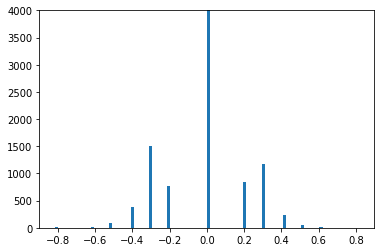

In [11]:
a = tf.reshape(model_cifar.trainable_weights[2],[-1])
#print(a)
plt.ylim(0,4000)
plt.hist(a,100)
plt.show()